#Lab features:

1. Keras for building model

2. Tensorboard for monitoring training process

3. Tensorflow eager execution

#Note: 
To execute a cell, press `Shift+Enter`

To change this Notebook, click on **File** at the top of this page then choose **Save a copy in Drive**. Then go to your Google Drive, and find the newly created file and open it with **Colab**.


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import datetime

print("Tensorflow version: ", tf.__version__)
tf.executing_eagerly()  # enable eager execution

Tensorflow version:  2.4.1


True

In [ ]:
# Helper function for plotting predictions

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("Pred {} {:2.0f}% (True {})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

#1. MNIST Dataset

MNIST dataset is made of 70000 (60000 for training and 10000 for testing) grey scale images of handwritten digits. The digits are size-normalized and centered in a fixed-size image of size 28x28.

Since Keras offers API for accessing MNIST, we can directly load this dataset to this Notebook while avoiding the harsh of parsing the raw dataset.

In [ ]:
# Load the dataset and split it to trainning set and test set
mnist = keras.datasets.mnist
# Split the dataset into trainning set and test set
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

##1.1 Explore the data

`train_images` is 3D tensor. Like an RGB image made of 3 channels (Red, Green, Blue) each represents an image, `train_images` has 60000 channels, each channel is a grey scale image of size 28x28.

In [ ]:
print("shape of train_images: ", train_images.shape)
print("type of train_images: ", type(train_images))

shape of train_images:  (60000, 28, 28)
type of train_images:  <class 'numpy.ndarray'>


`train_labels` stores the label of every image in `train_image` and is organized with the same order as `train_image`.

In [ ]:
print("shape of train_labels: ", train_labels.shape)
print("type of train_images: ", type(train_labels))

shape of train_labels:  (60000,)
type of train_images:  <class 'numpy.ndarray'>


In [ ]:
class_names = np.unique(train_labels)
print("All labels in the dataset:\n", class_names)

All labels in the dataset:
 [0 1 2 3 4 5 6 7 8 9]


Let's display some data samples

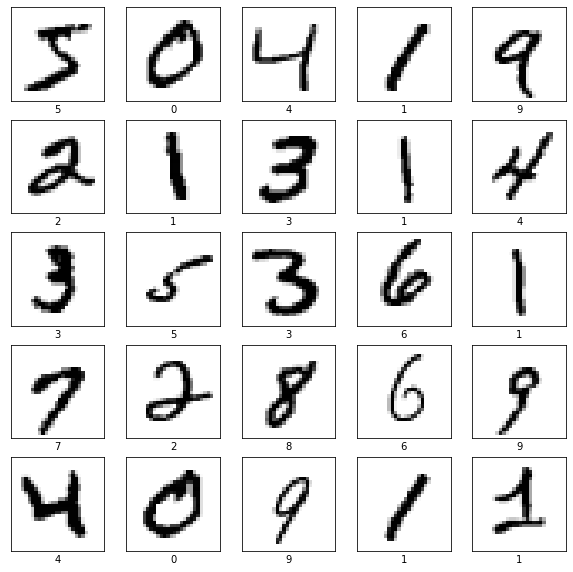

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Scale images to the range of (0, 1) before training and split train, validation set

If this step is not done, the model can't learn.

In [ ]:
train_images, test_images = train_images / 255.0, test_images / 255
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

ratio = 0.01
print('split train set to train:val={}:{}'.format(1-ratio, ratio))
from sklearn.model_selection import train_test_split
train_images, val_images,train_labels, val_labels = train_test_split(train_images, train_labels, test_size=ratio)
print(train_images.shape)
print(val_images.shape)
print(train_labels.shape)
print(val_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
split train set to train:val=0.99:0.01
(59400, 28, 28)
(600, 28, 28)
(59400,)
(600,)


#2. Fully Connected Network (FCN)

An FCN shown below is a stack of fully (densely) connected layers. Each layer is an array of neurons, each of which carries out two operators. The first operator is the weighted sum of all input to a neuron, while the second is a non-linear function (e.g. sigmoid, relu).   

<figure>
<center>
<img src='https://drive.google.com/uc?id=1qwdkn9y9L4S2Ue0NtUIRlplMFi6KAO1h'  width="450" height="400" />
<figcaption>An example of FCN</figcaption></center>
</figure>


##2.1 Building an FCN

Here, a shallow FCN (with only one hidden layer) is built as an example. 

In [ ]:
def fcn(input_shape):
  """
  Define a shallow FCN
  Input:
    input_shape [tuple]: shape of input image (height, width, channel)
  Output:
    model (a tensorflow model instance)
  """
  
  # Input layer
  X_in = keras.layers.Input(shape=input_shape)
  X = keras.layers.Flatten()(X_in)

  # Hidden layer
  X = keras.layers.Dense(512, activation='relu', name="fcn_hidden")(X)

  # Output layer
  y = keras.layers.Dense(10, activation='softmax', name="fcn_output")(X)

  model = keras.Model(inputs=X_in, outputs=y, name="fcn")
  return model


Create a model from the function defined above and checkout model's parameters

In [ ]:
model_fcn = fcn((28, 28))
model_fcn.summary()

Model: "fcn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
fcn_hidden (Dense)           (None, 512)               401920    
_________________________________________________________________
fcn_output (Dense)           (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Compile the model by declaring the optimizer used for training and the loss function. The argument `metrics` are just for monitoring the training process, they don't have any effect on model training (i.e. adjusting model's weights to reduce value of loss function).   

In [ ]:
#tf.keras.losses.SparseCategoricalCrossentropy(),
model_fcn.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

## 2.2 Training the model
While training, the evolution of model's `loss` and `accuracy` are logged so that they can be displayed later using `Tensorboard`

Note: the log file is stored locally in the machine (on the cloud) running this Notebook, therefore it will be erased when you close the web browser. To keep the log files, you can [mount your Google Drive into colab](https://colab.research.google.com/notebooks/io.ipynb) and set the variable `log_dir` to the path to the chosen Drive's folder. The path to your Drive should starts with `/content/drive/My Drive/`

In [13]:
%rm -rf logs/fit/fcn_m
log_dir = "logs/fit/" + "fcn_m"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
from keras.callbacks import EarlyStopping
early_stopping =  EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.0,
                            patience=5,
)

epoch = 2
bs = 1
# Fitting the dataset
model_fcn.fit(x=train_images, 
          y=train_labels, 
          batch_size=bs,
          epochs=epoch, 
          validation_data=(val_images, val_labels), 
          callbacks=[tensorboard_cb, early_stopping])

Epoch 1/2
59400/59400 [==============================] - 94s 2ms/step - loss: 0.3145 - accuracy: 0.9065 - val_loss: 0.1734 - val_accuracy: 0.9683
Epoch 2/2
59400/59400 [==============================] - 92s 2ms/step - loss: 0.1479 - accuracy: 0.9659 - val_loss: 0.2118 - val_accuracy: 0.9633


Launch `Tensorboard` to check the evolution of loss and accuracy. This can take several seconds depend on your internet connection. 

In the GUI below, you can find several infomation about the model beside the `loss` and `accuracy` such as model's architecture in the `GRAPHS` window.

In [14]:
# you will need to change the date and time
%tensorboard --logdir logs/fit/fcn_m

Reusing TensorBoard on port 6006 (pid 3755), started 0:06:12 ago. (Use '!kill 3755' to kill it.)

<IPython.core.display.Javascript object>

##2.3 Making predictions

In [15]:
# Get model's prediction for test set
predictions = model_fcn.predict(test_images)

For a classification task, model outputs an array of probability of an image to belong to each class of object thanks to the output layer made of `softmax` activated neurons.

Let's checkout the prediction for the first image in the test set

In [16]:
print("Prediction for the first test image: ", predictions[0])

Prediction for the first test image:  [1.2095875e-18 5.5982730e-22 2.8021715e-13 9.6133626e-13 3.4106982e-23
 1.3157891e-16 2.2377844e-27 1.0000000e+00 6.3599019e-24 5.5595120e-17]


The class of object this image belong to is decided by the class which the model assigns the highest probability to

In [17]:
print("Predicted class of the first test image: ", np.argmax(predictions[0]))
print("True label of the first test image: ", test_labels[0])

Predicted class of the first test image:  7
True label of the first test image:  7


To have a clearer visualization of model's predictions, let's display some test images along with their prediction and true labels.

In [18]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
'''
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()
'''
score = model_fcn.evaluate(test_images, test_labels, verbose=0)
print('*** test result for Fully Connected Networks ***')
print('Test loss:', score[0])
print('Test accuracy:', score[1])



*** test result for Fully Connected Networks ***
Test loss: 0.2118808627128601
Test accuracy: 0.9625999927520752


#3. Convolution Neural Network (CNN)

#3.1 Limitation of FCN:
Depiste the FCN does great on MNIST testing dataset (98% of accuracy), FCN poses 3 major limitations. 

Firstly, FCNs do not scale well for images since the size of the first hidden layer is equal to the area of input image. To process a high resolution image, for example 1080p, of the size 1920×1080, the first hidden layer contains more than 1 million neurons.

Secondly, the `Flatten` layer discards all the information brought by pixel position and the correlation between one pixel and its neighbors. This information is highly valuable for cognition task. The reason for this claim can be explained intuitively by fact that we get the context of an image by looking at a sufficiently big chunk of pixel, not by focusing on only one pixel.

Finally, FCNs behave differently when objects appear at different positions. In other word, FCNs are not transition invariant. "For example, if a picture of a cat appears in the top left of the image in one picture and the bottom right of another picture, the MLP will try to correct itself and assume that a cat will always appear in this section of the image." ([source](https://https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac))

<figure>
<center>
<img src='https://drive.google.com/uc?id=1Iau04cM3J_esZDTUVCrSBck7RmEHvhDe' width="450" height="200"/>
<figcaption>A FCN-based cat detector adjusts its weights according to where the cat appears</figcaption></center>
</figure>

These limitations call for a development of new learning architecture. The Convolution Layer - the core of Convolution Neural Network is the most successful answer to this call.

#3.2 The Convolution Layer

A convolution layer is made of a stack of **filters**. Each filter is stack of **kernels** with the number of kernels in the stack equal to the `depth` of input. A kernel is an 2D array of weights (i.e. matrix). A convolution layer takes in a tensor (a stack of matrix) of size `W_in x H_in x D_in` and produces an output tensor size `W_out x H_out x D_out`. Here, `W_out` and `H_out` are defined by kernels' size (this implied all kernels have the same size). `D_out` is the numer of filters, which means each filter contributes an **2D feature map** to the final output. A brief illustration of how convolution layer work can be found in [this video](https://youtu.be/jajksuQW4mc) made by Udacity.  

Next the operation of convolution layer is illustrated.

##3.2.1 Convolution with single channel input

When inputs are gray scale images (such as MNIST dataset), the inputs' depth is 1, thus each filter is made of 1 kernel. In this particular case, the two terms **filters** and **kernels** are interchangable (which sometimes causes confusion). 

The 2D convolution illustrated in figure ([source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)) below is made of 3 steps:
  * Slide a kernel across the input
  * Element-wise multiplication
  * Element-wise sum

<figure>
<center>
<img src='https://drive.google.com/uc?id=10XjS0dOAw-mr9Y0-IUorcaPAzTwRmjDn'/>
<figcaption>Convolution with single channel input.</figcaption></center>
</figure>

This operation can be crossed check with Tensorflow's implementation of `Conv2D` layer.

In [19]:
# Create a single-channel random tensor (i.e. a matrix) of size 5x5
t1 = tf.random.uniform(shape=(5, 5), minval=0, maxval=255, dtype=tf.dtypes.float32, seed=7)
print("t1 (before reshape): \n",t1)

# reshape t1 so that it can be fed to a Conv2D layer
# the 1st number of "shape" is the batch_size (the number of images fed to 
# the network at training time)
# the 2nd number is input's width which is 5 in this case
# the 3rd number is input's height (5 as well)
# the last number is input's depth which is 1
t1 = tf.reshape(t1, shape=[1, 5, 5, 1]) 


t1 (before reshape): 
 tf.Tensor(
[[123.404945 129.08177   65.06166   31.809278 237.91757 ]
 [169.47537   58.452232 215.27794  196.1214   140.53638 ]
 [238.79706   27.853205 210.98756   42.35952   41.31403 ]
 [ 75.15212  135.05649   69.2159   224.77025   14.689526]
 [195.23306  206.26138   38.13442  150.9252    96.464874]], shape=(5, 5), dtype=float32)


In [20]:
# Create a Conv2D layer whose weights are randomly initialized
# for testing the convolution operation, this layer has only 1 filter
# the filter has 1 kernel (due to input's depth of 1) of size 3x3
conv2d_single = keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), padding='valid', name="conv2d_single")

In [21]:
# Get the ouput of applying conv2d_single on t1
out_single = conv2d_single(t1)
print("out_single: \n", out_single)

# Since out_single is in the tensor form, its display is not clear,
# let's convert it to numpy array and drop all the dimension equal to 1 (using squeeze())
out_single_numpy = out_single.numpy().squeeze()
print("\nout_single_numpy (beautify): \n", out_single_numpy)

out_single: 
 tf.Tensor(
[[[[ 23.629393]
   [207.20294 ]
   [123.02942 ]]

  [[200.93167 ]
   [-29.830088]
   [177.91472 ]]

  [[230.36818 ]
   [-67.68744 ]
   [229.27101 ]]]], shape=(1, 3, 3, 1), dtype=float32)

out_single_numpy (beautify): 
 [[ 23.629393 207.20294  123.02942 ]
 [200.93167  -29.830088 177.91472 ]
 [230.36818  -67.68744  229.27101 ]]


In [22]:
# Get the kernel
weights = conv2d_single.get_weights()
print("weights is a ", type(weights), " of ", type(weights[0]))
print("Number of filters: ", len(weights))

# Even though weights contains 2 elements, the last elements is empty,
# Hence the true number of fitlers is 1
if not weights[1]:
  print("\nThe 2nd element of weights is empty.")
  print("The true number of filters: ", len(weights)-1)

# Get the kernel of the 1st (and only) filter
kernel = weights[0].squeeze()
print("\nKernel: \n", kernel)

weights is a  <class 'list'>  of  <class 'numpy.ndarray'>
Number of filters:  2

The 2nd element of weights is empty.
The true number of filters:  1

Kernel: 
 [[ 0.5294268  -0.5731855   0.02316707]
 [ 0.33785427  0.26588905  0.04181373]
 [-0.22350451  0.46731424 -0.05056846]]


In [23]:
# To validate the theory explained at the beginning of this sub section,
# let's try calculating the first number in the conv2d_single's output

# Since the Conv2D layer is defined with "valid" padding, the first number in its
# output is produce by convolving the top-left corner 3x3 block of the input
# with the kernel

# Proceed the 2nd step of convolution - element-wise multiplication
# Note that, t1 has been reshaped into a 4D tensor so that it can be fed into
# the Conv2D layer. 
mul_ = t1[0, 0:3, 0:3, 0] * kernel
print("Element-wise multiplaicaiton:\n", mul_)

# 3rd step: element-wise sum
sum_ = tf.math.reduce_sum(mul_)

# Check the output
# This output should be close the first element of out_single_numpy 
assert(np.abs(sum_ - out_single_numpy[0, 0]) < 1e-3)
print("\nManual convolution result: ", sum_.numpy())

Element-wise multiplaicaiton:
 tf.Tensor(
[[ 65.333885  -73.9878      1.5072883]
 [ 57.257977   15.541808    9.001574 ]
 [-53.37222    13.016199  -10.669316 ]], shape=(3, 3), dtype=float32)

Manual convolution result:  23.629398


###3.2.2 Convolution with multi channels input

In this case, each **filter** is a stack of **kernels**. A filter's depth is equal to the depth of input images. 

For a filter to produce a **2D feature map**, each of its kernels is applied to the inputs' channel at the same depth to produce an *intermediate* feature map. These intermediate feature maps are then sum element-wise to result in the *final* feature map. This process is illustrated below ([source](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215))

<figure>
<center>
<img src='https://drive.google.com/uc?id=1WinRqO7DV1qRwYUJkMV8n4wowCw0yURH' height="150"/>
</figure>
<figure>
<center>
<img src='https://drive.google.com/uc?id=1GfDPMf7IHVonG-em6VJUT_Pj4REbcIp4' height="150"/>
<figcaption>Convolution with multi channels input.</figcaption></center>
</figure>

To check this definition, let's again calculate the output of Tensorflow Conv2D layer and compare it to a manual construction Conv2D layer.

In [24]:
# Create a random tensor of size 5x5x3
t2 = tf.random.uniform(shape=(5, 5, 3), minval=0, maxval=255, dtype=tf.dtypes.float32, seed=7)

# checkout the first channel
print("First channel:\n", t2[:, :, 0])

# reshape t2 into a 4D tensor so that it can be fed into Conv2D layer
t2 = tf.reshape(t2, shape=(1, 5, 5, 3))

First channel:
 tf.Tensor(
[[214.96742   86.603065  75.75371   72.984116  62.40697 ]
 [201.86253  146.16362  191.15242   11.084066  98.09435 ]
 [210.99307  157.7478   171.66254  107.12829   11.667259]
 [144.01303  200.86243  198.87437   36.742752 130.67278 ]
 [ 34.1353    65.48064  227.48932  124.03389  106.71174 ]], shape=(5, 5), dtype=float32)


In [25]:
# create a new Conv2D layer
conv2d_multi = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), padding='valid', name="conv2d_multi")

In [26]:
# Feed t2 into conv2d_multi and checkout the output
out_multi = conv2d_multi(t2)

out_multi_numpy = out_multi.numpy().squeeze()
print("\nout_multi_numpy (beautify): \n", out_multi_numpy)


out_multi_numpy (beautify): 
 [[343.69336 351.8245  252.60553]
 [440.44583 207.86429 357.6176 ]
 [244.93178 272.03976 256.08008]]


In [27]:
# Get filter
weights_multi = conv2d_multi.get_weights()
filter_ = weights_multi[0]
print("Shape of filter_: ", filter_.shape)

# Display kernels
for i in range(filter_.shape[2]):
  print("\nkernel %d: \n" % i, filter_[:, :, 0].squeeze())

Shape of filter_:  (3, 3, 3, 1)

kernel 0: 
 [[ 0.08372426 -0.22537732  0.31639326]
 [ 0.18549782 -0.20254579 -0.34321335]
 [-0.02813849  0.0880959   0.22336447]]

kernel 1: 
 [[ 0.08372426 -0.22537732  0.31639326]
 [ 0.18549782 -0.20254579 -0.34321335]
 [-0.02813849  0.0880959   0.22336447]]

kernel 2: 
 [[ 0.08372426 -0.22537732  0.31639326]
 [ 0.18549782 -0.20254579 -0.34321335]
 [-0.02813849  0.0880959   0.22336447]]


In [28]:
# Mannually calculate the Convolution between t2 and the filter made of 3 kernels above
# this calculation is just to check the first element of out_multi_numpy
# which is the result of convolution with the top-left 3x3 block of t2

sum_0 = tf.math.reduce_sum(t2[0, :3, :3, 0] * filter_[:, :, 0].squeeze())
sum_1 = tf.math.reduce_sum(t2[0, :3, :3, 1] * filter_[:, :, 1].squeeze())
sum_2 = tf.math.reduce_sum(t2[0, :3, :3, 2] * filter_[:, :, 2].squeeze())

sum_fin = sum_0 + sum_1 + sum_2

# Check output
assert(np.abs(sum_fin - out_multi_numpy[0, 0])<1e-3)

## 3.3 LeNet-5

In [29]:
def leNet5(input_shape):
  """
  Define the LeNet-5
  Input:
    input_shape [tuple]: shape of input image (height, width, channel)
  Output:
    model (a tensorflow model instance)
  """
  
  # Input layer
  X_in = keras.layers.Input(shape=input_shape)
  
  
  # Conv2D layer
  X = keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), 
                          activation='tanh', 
                          padding='same', name="leNet5_conv1")(X_in)
  
  # Pooling layer
  X = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(X)

  # Conv2D
  X = keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), 
                          activation='tanh', 
                          padding='valid', name='leNet5_conv2')(X)

  # Pooling layer
  X = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(X)

  # Conv2D
  X = keras.layers.Conv2D(filters=120, kernel_size=(5, 5), strides=(1, 1), 
                          activation='tanh', 
                          padding='valid', name='leNet5_conv3')(X)
  
  # Flatten CNN output so that it can be connected to dense layer
  X = keras.layers.Flatten()(X)

  # Dense
  X = keras.layers.Dense(84, activation='tanh')(X)

  # Output layer
  y = keras.layers.Dense(10, activation='softmax')(X)

  model = keras.Model(inputs=X_in, outputs=y, name='leNet5')
  return model

In [30]:
model_leNet5 = leNet5((28, 28, 1))
model_leNet5.summary()

Model: "leNet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
leNet5_conv1 (Conv2D)        (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 27, 27, 6)         0         
_________________________________________________________________
leNet5_conv2 (Conv2D)        (None, 23, 23, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 11, 11, 16)        0         
_________________________________________________________________
leNet5_conv3 (Conv2D)        (None, 7, 7, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5880)              0    

In [31]:
otptim_algorithm = 'adam'
model_leNet5.compile(optimizer=otptim_algorithm,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
train_images = train_images.reshape(train_images.shape + (1, ))
test_images = test_images.reshape(test_images.shape + (1, ))

##Note:

Training CNN can take a significantly long time on CPU. Luckily Colab offers GPU for short amount of usage. To save time, you can switch `Runtime` to GPU when trains LeNet-5 by clicking on the tag **Runtime** on top of this page and choose **change runtime type**. In the newly opened window, set **hardware acceleration** to GPU. After this selection, you will need to **rerun the whole Notebook from the very top** with **skipping** Section 3.1 and Section 3.2.

In [ ]:
log_dir = "logs/fit/" + "leNet-5"
%rm -rf "logs/fit/leNet-5"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping =  EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.0,
                            patience=5,
)
epoch = 30
bs = 16
# Fitting the dataset
history = model_leNet5.fit(x=train_images, 
            y=train_labels, 
            epochs=epoch,
            batch_size = bs, 
            validation_data=(val_images, val_labels), 
            callbacks=[tensorboard_cb])

Epoch 1/30
3713/3713 [==============================] - 13s 3ms/step - loss: 0.3699 - accuracy: 0.8883 - val_loss: 0.2321 - val_accuracy: 0.9317
Epoch 2/30
3713/3713 [==============================] - 12s 3ms/step - loss: 0.2006 - accuracy: 0.9396 - val_loss: 0.1672 - val_accuracy: 0.9483
Epoch 3/30
3713/3713 [==============================] - 11s 3ms/step - loss: 0.1539 - accuracy: 0.9530 - val_loss: 0.1399 - val_accuracy: 0.9567
Epoch 4/30
3713/3713 [==============================] - 11s 3ms/step - loss: 0.1272 - accuracy: 0.9612 - val_loss: 0.1027 - val_accuracy: 0.9683
Epoch 5/30
3713/3713 [==============================] - 11s 3ms/step - loss: 0.1166 - accuracy: 0.9646 - val_loss: 0.1196 - val_accuracy: 0.9650
Epoch 6/30
3713/3713 [==============================] - 11s 3ms/step - loss: 0.1021 - accuracy: 0.9688 - val_loss: 0.1010 - val_accuracy: 0.9733
Epoch 7/30
3713/3713 [==============================] - 11s 3ms/step - loss: 0.0923 - accuracy: 0.9727 - val_loss: 0.1006 - val_ac

#4. Compare performance of FCN and LeNet-5
# TODO:

Now, it's your turn to compare the accuracy of LeNet-5 and FCN.

In [ ]:
#check  the training process of Lenet5
%tensorboard --logdir logs/fit/leNet-5

score_LeNet = model_leNet5.evaluate(test_images, test_labels, verbose=0)
print('*** test result for Fully Conv Networks (LeNet5)***')
print('Test loss:', score_LeNet[0])
print('Test accuracy:', score_LeNet[1])


# Get model's prediction for test set
predictions_LeNet = model_leNet5.predict(test_images)




### Reference:
https://www.tensorflow.org/tutorials/keras/classification

https://www.tensorflow.org/tensorboard/get_started

https://engmrk.com/lenet-5-a-classic-cnn-architecture/

https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac